## Imports

In [1]:
import geopandas as gpd
import os, sys, copy, shutil, subprocess
import pathlib as pl
import fiona
import descartes
import json
import numpy as np
import sys
import logging
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
sys.path.append('..')
from src import config
from src.data import process_inputs
from src.data import utils 
from src.grass_functions import *

### Get HUC number

In [2]:
huc_list_path = pl.Path(os.getcwd()).parent/'huc8.txt'
with open(huc_list_path, 'r') as txt_file:
    huc_list = []
    txt_reader = txt_file.read().splitlines() 
    for huc in txt_reader:
        huc_list.append(huc)

In [3]:
huc = huc_list[0]
logger.info("Selected 1st huc from list " + huc)

[2022-03-24 01:28:36,635] [INFO] [601608545] : Selected 1st huc from list 11030006


### Configure

In [4]:
os.environ["APP_ENV"] = 'LOCAL'
config = config.create_config(huc)

### Get HUC vector

In [5]:
#get huc 
huc4 = huc[:4]
huc_level = len(huc)
nhd = process_inputs.download_nhd(
        huc4=huc4, 
        gdb_dir=config.root/config.nhd.out_file.gdb, 
        overwrite=overwrite
        )
local_hucs = gpd.read_file(nhd, layer='WBDHU{}'.format(huc_level))
process_inputs.write_file(local_hucs,config.root/config.huc_bounds.in_file)


# HUC boundaries 
logger.info("reprojecting HUC {0} boundary shapefile to EPSG {1}".format(huc_level,config.sr))
gdf =process_inputs.get_huc_boundary(
    gdb_path=config.root/config.nhd.out_file.gdb, 
    out_file=config.root/config.huc_bounds.out_file.geojson, 
    huc=huc, 
    sr=config.sr, 
    overwrite=overwrite
)

[2022-03-24 01:28:36,739] [INFO] [process_inputs] : NHD download already exists; not redownloading.
[2022-03-24 01:28:39,093] [INFO] [2951952384] : reprojecting HUC 8 boundary shapefile to EPSG 5070


<AxesSubplot:>

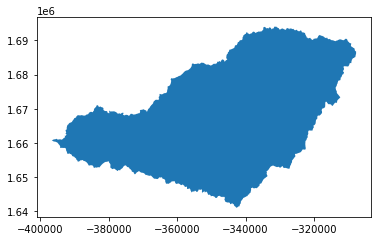

In [6]:
gdf.plot()

### Start grass session

In [7]:
config = create_grass_session(huc,config, overwrite=False)

[2022-03-24 01:28:41,976] [INFO] [utils] : creating timestamped log directory: /home/logs/huc11030006/20220324-012841
[2022-03-24 01:28:41,999] [INFO] [utils] : setting up GRASS session for HUC 11030006, EPSG 5070
[2022-03-24 01:28:42,840] [INFO] [utils] : GRASS session set up: {'GISDBASE': '/home/grassdata', 'LOCATION_NAME': 'huc11030006_sr5070', 'MAPSET': 'ML'}


### Import Flow Direction & Points

In [8]:
directory = config.root/'FlowDirection'
out_name = 'flow_dir'

In [9]:
patch_rasters(config,directory,out_name)

Patching together 10 rasters


   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100


Created: flow_dir


Removing raster <ed_flowdir>
Removing raster <FI_FlowDir>
Removing raster <FO_FlowDir>
Removing raster <GY_FlowDir>
Removing raster <hg_flowdir>
Removing raster <le_flowdir>
Removing raster <NS_FlowDir>
Removing raster <pn_flowdir>
Removing raster <rh_flowdir>
Removing raster <sc_flowdir>


In [9]:
reg = gs.parse_command('g.region',raster=out_name,flags='pgm')

ERROR: Raster map <flow_dir> not found


CalledModuleError: Module run None g.region -pgm raster=flow_dir ended with error
Process ended with non-zero return code 1. See errors in the (error) output.

In [11]:
reg

{'projection': '99',
 'zone': '0',
 'n': '1753305.57046354',
 's': '1608903.28614222',
 'w': '-445356.68790219',
 'e': '-248785.30957958',
 'nsres': '0.99794253',
 'ewres': '0.99794077',
 'rows': '144700',
 'cols': '196977',
 'cells': '28502571900'}

In [12]:
#reformat arc hydro to grass
gs.mapcalc("{0}_grass = if({0} == 1,8,if({0} ==2,7,if({0} == 4,6,if({0} == 8,5,if({0} == 16,4,if({0} == 32,3,if({0} == 62,2,if({0} == 128,1))))))))".format(out_name))

In [13]:
gs.run_command('g.remove', type ='raster', name=out_name, flags ='f')

Removing raster <flow_dir>


0

In [9]:
reg = gs.parse_command('g.region',raster='{0}_grass'.format(out_name),flags='pgm')

In [10]:
reg

{'projection': '99',
 'zone': '0',
 'n': '1753305.57046354',
 's': '1608903.28614222',
 'w': '-445356.68790219',
 'e': '-248785.30957958',
 'nsres': '0.99794253',
 'ewres': '0.99794077',
 'rows': '144700',
 'cols': '196977',
 'cells': '28502571900'}

In [14]:
gs.run_command('v.import', input=  config.root/'pour_points'/'pawnee'/'watershed_delineation_points.shp',extent='region', output= 'pour_points')


         Location PROJ_INFO is:
         name: NAD83 / Conus Albers
         datum: nad83
         ellps: grs80
         proj: aea
         lat_0: 23
         lon_0: -96
         lat_1: 29.5
         lat_2: 45.5
         x_0: 0
         y_0: 0
         no_defs: defined
         init: EPSG:5070

         Dataset PROJ_INFO is:
         name: NAD83 / Kansas South (ftUS)
         datum: nad83
         ellps: grs80
         proj: lcc
         lat_0: 36.6666666666667
         lon_0: -98.5
         lat_1: 38.5666666666667
         lat_2: 37.2666666666667
         x_0: 399999.99998984
         y_0: 399999.99998984
         no_defs: defined

         ERROR: proj
Importing </home/data/pour_points/pawnee/watershed_delineation_points.shp>
...
Check if OGR layer <watershed_delineation_points> contains polygons...
   0   2   5   8  11  14  17  20  22  25  28  31  34  37  40  42  45  48  51  54  57  60  62  65  68  71  74  77  80  82  85  88  91  94  97 100
Creating attribute table for layer <waters

0

In [20]:
#import watershed vectors,
logger.info("importing huc boundary")
gs.run_command('v.import', input=config.root/config.huc_bounds.out_file.geojson, output="huc",overwrite = True)
gs.run_command('v.buffer', input='huc', output='hucbuff', distance=config.huc_buff) 

[2022-03-23 01:06:14,009] [INFO] [2701368757] : importing huc boundary
Check if OGR layer <huc11030006_sr5070> contains polygons...
   0 100
Creating attribute table for layer <huc11030006_sr5070>...
Importing 1 features (OGR layer <huc11030006_sr5070>)...
   0 100
-----------------------------------------------------
Registering primitives...
-----------------------------------------------------
Cleaning polygons
-----------------------------------------------------
Breaking polygons...
Breaking polygons (pass 1: select break points)...
 100
Breaking polygons (pass 2: break at selected points)...
 100
-----------------------------------------------------
Removing duplicates...
 100
-----------------------------------------------------
Breaking boundaries...
   0 100
-----------------------------------------------------
Removing duplicates...
 100
-----------------------------------------------------
Cleaning boundaries at nodes...
 100
-------------------------------------------------

0

In [21]:
gs.run_command('r.mask', vector="hucbuff")

Reading areas...
   0 100
Writing raster map...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Reading areas...
   0 100
Writing raster map...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Reading areas...
   0 100
Writing raster map...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Reading areas...
   0 100
Writing raster map...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Reading areas...
   0 100
Writing raster map...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Reading areas...
   0 100
Writing raster map...
   0   

0

In [11]:
config.mem = 18000

In [14]:
config.drain_dir = '{0}_grass'.format(out_name)

In [19]:
directory = config.root/'accum'
out_name = 'accum_pw'
config.accum = out_name

In [20]:
patch_rasters(config,directory,out_name)

Patching together 10 rasters


   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100


Created: accum_pw


Removing raster <ed_flowacc>
Removing raster <FI_FlowAcc>
Removing raster <FO_FlowAcc>
Removing raster <GY_FlowAcc>
Removing raster <hg_flowacc>
Removing raster <le_flowacc>
Removing raster <NS_FlowAcc>
Removing raster <pn_flowacc>
Removing raster <rh_flowacc>
Removing raster <sc_flowacc>


### Create Basin Delineation

In [21]:
v_basins = 'pawnee_wal_basin_v'
r_basins = 'pawnee_wal_basin_r'
cell_area = (float(reg['nsres']) * float(reg['ewres']))

In [22]:
gs.run_command("r.stream.snap", 
                       input= 'pour_points',
                   output ='{}_snapped'.format('pour_points'),
                  radius=(40), accumulation= config.accum, threshold = (config.thresholds['stream'] // cell_area)*10)

Reading raster map <accum_pw>...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
         search radius.
         search radius.
         search radius.
         search radius.
         search radius.
         search radius.
         search radius.
         search radius.
         search radius.
         search radius.
         search radius.
         search radius.
         search radius.
         search radius.
         search radius.
         search radius.
         search radius.
         search radius.
         search radius.
         search radius.
         search radius.
         search radius.
         search radius.
         search radius.
         search radius.
         search radius.
         search radius.
         search radius.
         search radius.
         search radius.
         search radius.
         search radius.
         search radius.
         search radius.
Building t

0

In [27]:
reg = gs.parse_command('g.region',raster=config.drain_dir,align=config.drain_dir,flags='pgm')

In [28]:
gs.run_command("r.stream.basins", 
                       direction = config.drain_dir,
                       basins = r_basins,
                       points ='{}_snapped_pawnee'.format('pour_points'),
                       memory = config.mem,
                       overwrite=True,
                       flags ='m'
                  )

Memory swap calculation (may take some time)...
Reading raster map <flow_dir_grass>...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Calculating basins using vector point map...
Delineating basins for 10 outlets...
   0  10  20  30  40  50  60  70  80  90 100
Writing raster map <pawnee_wal_basin_r>...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100


0

In [35]:
out_dir = config.root/'outputs'

In [38]:
gs.run_command('r.to.vect',input = r_basins,output = v_basins, type = 'area')
gs.run_command('v.clean',input = v_basins,threshold = 5000*cell_size,tool='rmarea',output = '{}_clean'.format(v_basins))

         overwritten
Extracting areas...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Writing areas...
   0   4   8  12  16  20  24  28  32  36  40  44  48  52  56  60  64  68  72  76  80  84  88  92  96 100
Building topology for vector map <pawnee_wal_basin_v@ML>...
Registering primitives...
Building areas...
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
Attaching islands...
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
Attaching centroids...
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  

0

In [39]:
logger.info('Exporting accumulation raster to : {}'.format(out_dir))
plot_grass_layer('{}_clean'.format(v_basins), str(config.log.out/"basins.png"), vector=True)

[2022-03-31 22:41:18,033] [INFO] [2771055374] : Exporting accumulation raster to : /home/data/outputs
ERROR: Raster map <pawnee_wal_basin_v_clean> not found
d.vect complete.
d.vect complete.
d.vect complete.


In [40]:
gs.run_command('v.out.ogr', input=  '{}_clean'.format(v_basins) ,type = 'area',output = config.root/'outputs'/'{}.gpkg'.format(v_basins), format = 'GPKG')

Exporting 2 areas (may take some time)...
  50 100
v.out.ogr complete. 2 features (Polygon type) written to
<pawnee_wal_basin_v_clean> (GPKG format).


0

## End

In [24]:
gs.run_command('v.import', input=  config.root/'pour_points'/'fpp.shp',extent='region', output= 'pour_points')


         Location PROJ_INFO is:
         name: NAD83 / Conus Albers
         datum: nad83
         ellps: grs80
         proj: aea
         lat_0: 23
         lon_0: -96
         lat_1: 29.5
         lat_2: 45.5
         x_0: 0
         y_0: 0
         no_defs: defined
         init: EPSG:5070

         Dataset PROJ_INFO is:
         name: NAD83 / Kansas South (ftUS)
         datum: nad83
         ellps: grs80
         proj: lcc
         lat_0: 36.6666666666667
         lon_0: -98.5
         lat_1: 38.5666666666667
         lat_2: 37.2666666666667
         x_0: 399999.99998984
         y_0: 399999.99998984
         no_defs: defined

         ERROR: proj
Importing </home/data/pour_points/pawnee/watershed_delineation_points.shp>
...
Check if OGR layer <watershed_delineation_points> contains polygons...
   0   2   5   8  11  14  17  20  22  25  28  31  34  37  40  42  45  48  51  54  57  60  62  65  68  71  74  77  80  82  85  88  91  94  97 100
Creating attribute table for layer <waters

0

### Create Accumulation Grid

In [ ]:
#for loop by HUC12

In [25]:
ppoints = gpd.read_file(config.root/'pour_points'/'pawnee'/'watershed_delineation_points.shp')

In [28]:
ppoints_nad = ppoints.to_crs(4269)

In [33]:
ppoints_nad['huc12'] = ppoints_nad.geometry.apply(lambda x: get_huc12(x.__geo_interface__['coordinates']))

In [35]:
ppoints_nad['upstream_list'] = ppoints_nad.huc12.apply(lambda x:get_upstream_basin_areas(x,'huc12'))

searching for upstream huc12 basins
found 8 upstream huc12s
searching for upstream huc12 basins
found 8 upstream huc12s
searching for upstream huc12 basins
found 8 upstream huc12s
searching for upstream huc12 basins
found 20 upstream huc12s
searching for upstream huc12 basins
found 2 upstream huc12s
searching for upstream huc12 basins
found 20 upstream huc12s
searching for upstream huc12 basins
found 58 upstream huc12s
searching for upstream huc12 basins
found 5 upstream huc12s
searching for upstream huc12 basins
found 7 upstream huc12s
searching for upstream huc12 basins
found 5 upstream huc12s
searching for upstream huc12 basins
found 5 upstream huc12s
searching for upstream huc12 basins
found 9 upstream huc12s
searching for upstream huc12 basins
found 9 upstream huc12s
searching for upstream huc12 basins
found 15 upstream huc12s
searching for upstream huc12 basins
found 15 upstream huc12s
searching for upstream huc12 basins
found 23 upstream huc12s
searching for upstream huc12 basin

In [37]:
first_pass = ppoints_nad.iloc[0]['upstream_list']

In [38]:
ppoints_nad.iloc[0]['huc12']

'110300060208'

In [ ]:
flow_dir = 'flow_dir_grass'

In [39]:
for huc12 in first_pass:
    short_value = huc12[-7:]
    GRASS_vector_files= [file for line in gs.list_strings(type='vector') for file in [line.split("@")[0]]]
    GRASS_raster_files= [file for line in gs.list_strings(type='raster') for file in [line.split("@")[0]]]
    accum = 'r_accum_'+huc12
    basins = 'basin_'+huc12
    v_basins = 'v_'+basins  
    gs.run_command('v.import', input= config.root/config.nhd.out_file.gdb, layer = 'WBDHU12',  output= huc12s)
    gs.run_command('v.extract', input =huc12s, where= "HUC12='%s'" % huc12, output = 'tmp_huc')
    gs.run_command('v.buffer',input='tmp_huc',output='tmp_huc_buffer',distance = config.huc_buff)
    gs.run_command('g.region',vector = 'tmp_huc_buffer',align=flow_dir)
    gs.run_command(
            'r.accumulate', 
            direction=flow_dir, 
            format='auto', 
            accumulation = accum,
            overwrite=True
        )
    gs.run_command("r.stream.snap", 
                       input= 'pour_points',
                   output ='{}_snapped'.format('pour_points'),
                  radius=(50), accumulation= config.accum, threshold = (config.thresholds['stream'] // cell_size**2)*15)
    gs.run_command('r.stream.basins',overwrite=True,\
                      direction=flow_dir,points='{}_snapped'.format('pour_points'),\
                      basins = basins)
    gs.run_command('r.mapcalc',overwrite=True,\
                  expression='%s = if(%s >= 0,%s,null())' %('out_'+basins,basins,short_value))
    


['110300060208',
 '110300060207',
 '110300060206',
 '110300060205',
 '110300060204',
 '110300060203',
 '110300060202',
 '110300060201']